In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import siepic_forge as siepic
import tidy3d as td
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer(port=5002)

Starting live viewer at http://localhost:5002


In [3]:
# Initialize the EBeam technology with top oxide removed (air cladding)
tech = siepic.ebeam(include_top_opening=True, top_oxide_thickness=0.0)

# Set default technology for PhotonForge simulations
pf.config.default_technology = tech

# Define wavelength sweep range
wavelengths = np.linspace(1.45, 1.65, 51)

In [4]:
# Define the width of the regular silicon strip waveguide (µm)
w_strip = 0.48

# Define the width of the subwavelength grating (SWG) equivalent waveguide (µm)
w_swg = 0.555

# Create a port specification for the strip waveguide
port_spec_strip = pf.PortSpec(
    description="Multi mode strip",  # descriptive label for identification
    width=2.5,  # total port width (simulation window)
    num_modes=2,  # number of supported optical modes
    target_neff=3.5,  # target effective index for solver initialization
    limits=(-1.5, 1.22),  # vertical boundaries of the simulation domain
    path_profiles=[
        (w_strip, 0, (1, 0))
    ],  # waveguide path geometry (width, offset, direction)
)

# Create a port specification for the SWG (subwavelength) waveguide
port_spec_swg = pf.PortSpec(
    description="Multi mode swg",
    width=2.5,
    num_modes=2,
    target_neff=3.5,
    limits=(-1.5, 1.22),
    path_profiles=[(w_swg, 0, (1, 0))],
)

Uploading task 'Mode-ModeSolver'…
Starting task 'Mode-ModeSolver': https://tidy3d.simulation.cloud/workbench?taskId=mo-52536067-dfb5-42bd-a110-7f59385723fb
Progress: 100%
Uploading task 'Mode-ModeSolver'…
Starting task 'Mode-ModeSolver': https://tidy3d.simulation.cloud/workbench?taskId=mo-ebf374df-d6f9-40d9-a324-74d71b87f54c
Progress: 100%


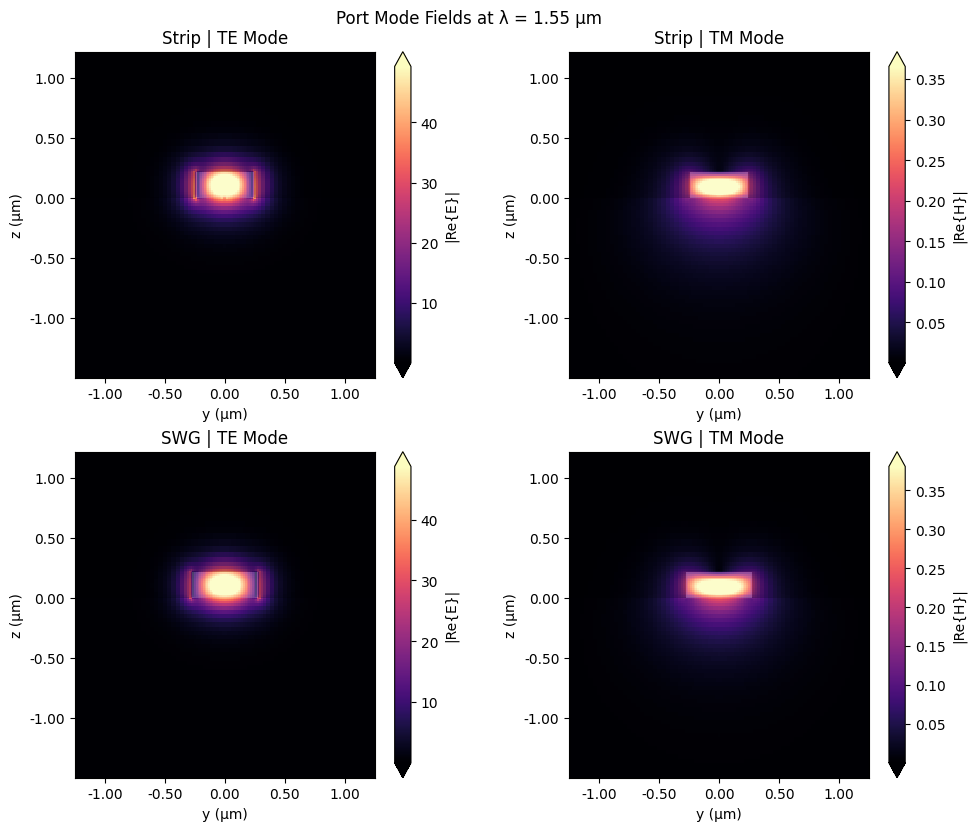

In [5]:
# Compute modes for both ports at 1.55 µm (f = c / λ)
f0 = pf.C_0 / 1.55

# Strip port modes
mode_solver_strip = pf.port_modes(port_spec_strip, [f0], mesh_refinement=30)

# SWG port modes
mode_solver_swg = pf.port_modes(port_spec_swg, [f0], mesh_refinement=30)

# Create a 2×2 figure layout for two modes (m=0,1) of both ports
fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

mode_solver_strip.plot_field("E", mode_index=0, f=f0, ax=axes[0, 0])
mode_solver_strip.plot_field("H", mode_index=1, f=f0, ax=axes[0, 1])
mode_solver_swg.plot_field("E", mode_index=0, f=f0, ax=axes[1, 0])
mode_solver_swg.plot_field("H", mode_index=1, f=f0, ax=axes[1, 1])
axes[0, 0].set_title("Strip | TE Mode")
axes[0, 1].set_title("Strip | TM Mode")
axes[1, 0].set_title("SWG | TE Mode")
axes[1, 1].set_title("SWG | TM Mode")
# Add a shared figure title
fig.suptitle("Port Mode Fields at λ = 1.55 µm", y=1.02)
plt.show()

In [6]:
# Define a parametric component for the SWG-assisted PBS
@pf.parametric_component
def create_pbs(
    *,
    spec_strip=port_spec_strip,
    spec_swg=port_spec_swg,
    w_corrugation=0.130,
    gap=0.200,
    swg_period=0.240,
    swg_duty_cycle=0.5,
    n_periods=30,
    s_bend_length=6,
    s_bend_offset=2,
):
    # Resolve string-based specs from the default technology if needed
    if isinstance(spec_strip, str):
        spec_strip = pf.config.default_technology.ports[spec_strip]
    if isinstance(spec_swg, str):
        spec_swg = pf.config.default_technology.ports[spec_swg]

    # Extract effective silicon widths from the provided PortSpecs
    w_strip, _ = spec_strip.path_profile_for("Si")
    w_swg, _ = spec_swg.path_profile_for("Si")

    # Compute total coupling length from SWG period and number of periods
    coupling_length = n_periods * swg_period

    # Create one SWG unit cell component consisting of ridge + groove
    unit_cell = pf.Component("SWG Period")

    # Build the ridge and groove rectangles for one period
    ridge_length = swg_duty_cycle * swg_period
    ridge = pf.Rectangle((0, -w_swg / 2), (ridge_length, w_swg / 2))
    groove = pf.Rectangle(
        (ridge_length, -w_swg / 2), (swg_period, w_swg / 2 - w_corrugation)
    )

    # Add ridge and groove into the unit cell along +x
    unit_cell.add((1, 0), ridge, groove)

    # Create the parent PBS component
    pbs = pf.Component("PBS")

    # Instantiate the SWG array by repeating the unit cell N times
    swg_array = pf.Reference(
        component=unit_cell, columns=n_periods, rows=1, spacing=(swg_period, 0.0)
    )

    # Add a short straight continuation for the SWG waveguide after coupling region
    swg_wg = pf.Rectangle(
        (coupling_length, -w_swg / 2),
        (coupling_length + s_bend_length + 0.1, w_swg / 2),
    )

    # Route the strip waveguide: lead-in, straight through coupler, then S-bend
    strip_wg = (
        pf.Path(origin=(-1.0, gap + (w_swg + w_strip) / 2), width=w_strip)
        .segment(endpoint=(coupling_length + 1.0, 0), relative=True)
        .s_bend(endpoint=(s_bend_length, s_bend_offset), relative=True)
    )

    # Add geometry to the PBS component (placed along +x)
    pbs.add((1, 0), swg_array, strip_wg, swg_wg)

    # Detect and add ports for strip (input) and SWG (output on +x boundary)
    pbs.add_port(pbs.detect_ports([spec_strip]))
    pbs.add_port(pbs.detect_ports([spec_swg], on_boundary="+x"))

    # Attach a Tidy3D model for simulation
    pbs.add_model(
        pf.Tidy3DModel(
            monitors=[
                td.FieldMonitor(
                    name="field",
                    center=(0, 0, 0.11),
                    size=(td.inf, td.inf, 0),
                    freqs=[pf.C_0 / 1.55],
                )
            ],
        )
    )
    return pbs


# Instantiate and view the PBS component with default parameters
pbs = create_pbs()
viewer(pbs)

In [7]:
s_matrix = pbs.s_matrix(
    frequencies=pf.C_0 / wavelengths, model_kwargs={"inputs": ["P0"]}
)

Uploading task 'P0@0'…
Uploading task 'P0@1'…
Starting task 'P0@0': https://tidy3d.simulation.cloud/workbench?taskId=fdve-7094670b-0d5a-40ed-8e87-9a95e2582654
Starting task 'P0@1': https://tidy3d.simulation.cloud/workbench?taskId=fdve-e63d2bc0-d310-48af-be8e-71c3f614eff7


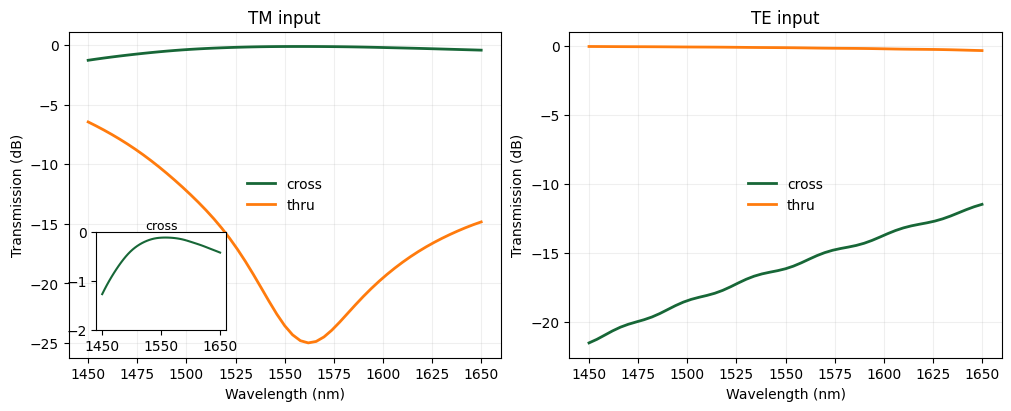

In [8]:
# Define key mapping for S-parameters
k_te_thru = ("P0@0", "P1@0")  # TE input → through
k_te_cross = ("P0@0", "P2@0")  # TE input → cross
k_tm_thru = ("P0@1", "P1@1")  # TM input → through
k_tm_cross = ("P0@1", "P2@1")  # TM input → cross


# Helper to convert complex S-parameter to transmission in dB
def s_to_db(s):
    """
    Return 10*log10(|S|^2) with small floor for numerical stability.
    """
    return 10.0 * np.log10(np.abs(s) ** 2 + 1e-18)


# Extract wavelength axis in nm
wl_nm = wavelengths * 1e3

# Create side-by-side plots for TM input and TE input
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# TM input: plot cross and thru
ax_tm = axes[0]
ax_tm.plot(wl_nm, s_to_db(s_matrix[k_tm_cross]), label="cross", linewidth=2)
ax_tm.plot(wl_nm, s_to_db(s_matrix[k_tm_thru]), label="thru", linewidth=2)
ax_tm.set_xlabel("Wavelength (nm)")
ax_tm.set_ylabel("Transmission (dB)")
ax_tm.set_title("TM input")
ax_tm.legend(loc="center", frameon=False)

# Optional inset for TM cross near 1450–1650 nm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax_tm, width="30%", height="30%", loc="lower left", borderpad=2)
axins.plot(wl_nm, s_to_db(s_matrix[k_tm_cross]), linewidth=1.5)
axins.set_xticks([1450, 1550, 1650])
axins.set_yticks([-2, -1, 0])
axins.set_title("cross", fontsize=9, pad=2)

# TE input: plot cross and thru
ax_te = axes[1]
ax_te.plot(wl_nm, s_to_db(s_matrix[k_te_cross]), label="cross", linewidth=2)
ax_te.plot(wl_nm, s_to_db(s_matrix[k_te_thru]), label="thru", linewidth=2)
ax_te.set_xlabel("Wavelength (nm)")
ax_te.set_ylabel("Transmission (dB)")
ax_te.set_title("TE input")
ax_te.legend(loc="center", frameon=False)

# Add an overall style tweak
for ax in axes.ravel():
    ax.grid(True, alpha=0.2)

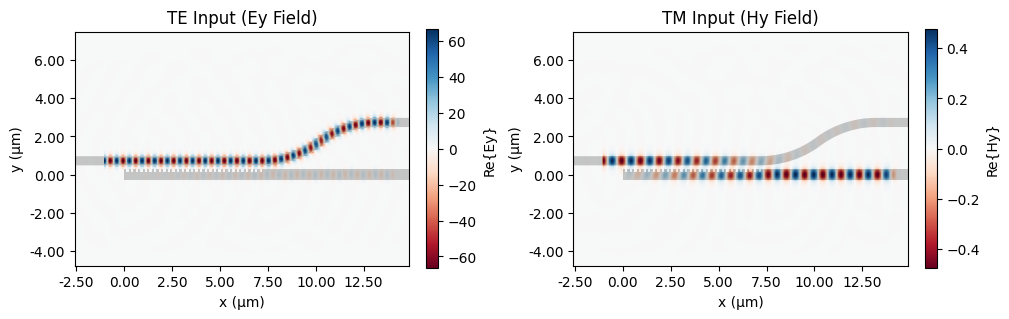

In [9]:
# Retrieve simulation field data for PBS model
sim_data_pbs = pbs.active_model.batch_data_for(pbs)

# Create a 1×2 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

# Plot Ey field for TE input (P0@0)
ax0 = sim_data_pbs["P0@0"].plot_field("field", "Ey", ax=axes[0], robust=False)
axes[0].set_title("TE Input (Ey Field)")

# Plot Hy field for TM input (P0@1)
ax1 = sim_data_pbs["P0@1"].plot_field("field", "Hy", ax=axes[1], robust=False)
axes[1].set_title("TM Input (Hy Field)")
plt.show()